In [1]:
import time

import numpy as np
import pandas as pd

import optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rcParams

from tqdm import tqdm

In [2]:
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
np.unique(df.iloc[:, -1].values - 1)

array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
df = pd.read_csv('smote/Cell_Response_resampled_df.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [59]:
activation_funcs = {
    'relu': nn.ReLU(),
    'tanh': nn.Tanh(),
    'RReLU': nn.RReLU(),
    'ReLU6': nn.ReLU6(),
    'LeakyReLU': nn.LeakyReLU(),
    'PReLU': nn.PReLU(),
    'GELU': nn.GELU(),
    'SELU': nn.SELU(),
    'CELU': nn.CELU(),
    'ELU': nn.ELU(),
    'SiLU': nn.SiLU()
}



class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes, dropout, activation_func):
        super(ClassificationModel, self).__init__()
        # Common first layer
        self.fc1 = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 256)
        self.drop2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(256, 512)
        self.drop3 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(512, 256)
        self.drop4 = nn.Dropout(dropout)
        self.fc5 = nn.Linear(256, 128)
        self.drop5 = nn.Dropout(dropout)
        self.fc6 = nn.Linear(128, num_classes)
        # Activation function
        self.activation = activation_funcs[activation_func]

    def forward(self, x):
        x = self.drop1(self.activation(self.fc1(x)))
        x = self.drop2(self.activation(self.fc2(x)))
        x = self.drop3(self.activation(self.fc3(x)))
        x = self.drop4(self.activation(self.fc4(x)))
        x = self.drop5(self.activation(self.fc5(x)))
        out = self.fc6(x)
        return out

In [61]:
criterion_options = {
    'MultiMarginLoss':nn.MultiMarginLoss(), 
    'CrossEntropyLoss':nn.CrossEntropyLoss()
}

def objective(trial):
    # Hyperparameters to tune
    activation_func = trial.suggest_categorical('activation_func', ['relu', 'tanh','RReLU', 'ReLU6', 'LeakyReLU', 
                                                                    'PReLU', 'GELU', 'SELU', 'CELU', 'ELU', 'SiLU' ])
    criterion_choices = trial.suggest_categorical('criterion', ['MultiMarginLoss', 'CrossEntropyLoss'])
    dropout = trial.suggest_float("dropout", 0.1, 0.5, log=True)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    num_epochs = trial.suggest_int("num_epochs", 500, 2000)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adadelta', 'Adagrad', 'Adam', 'AdamW','Adamax', 'ASGD', 
                                                             'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD'
                                                            ])
    
        
    model = ClassificationModel(input_size=X_train.shape[1], num_classes=len(np.unique(y_train)), dropout=dropout, activation_func=activation_func)
    model.to(device)
    criterion = criterion_options[criterion_choices]
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # Training loop
    num_epochs = num_epochs  
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    
    true_labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = model(inputs)
            true_labels.extend(labels.tolist())
            predictions.extend(preds.argmax(dim=1).tolist())
    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='macro')  

    return f1


storage = "sqlite:///Cell_Response3.db"
study = optuna.create_study(study_name="Cell_Response3", storage=storage, direction="maximize", load_if_exists=True)

study.optimize(objective, n_trials=150)  # Adjust the number of trials

print("Best trial:")
trial = study.best_trial

print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-09 21:56:54,973] Using an existing study with name 'Cell_Response' instead of creating a new one.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-09 21:59:27,703] Trial 160 finished with value: 0.057790368271954676 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.384098053617738, 'lr': 0.0007968195486771962, 'batch_size': 64, 'num_epochs': 1040, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[I 2024-04-09 22:19:24,442] Trial 166 finished with value: 0.7653845617072677 and parameters: {'activation_func': 'relu', 'criterion': 'CrossEntropyLoss', 'dropout': 0.23639231805696753, 'lr': 0.0008426410993917296, 'batch_size': 64, 'num_epochs': 1158, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-09 22:22:38,411] Trial 167 finished with value: 0.7954971604507232 and parameters: {'activation_func': 'relu', 'criterion': 'CrossEntropyLoss', 'dropout': 0.30634280291518956, 'lr': 0.00037771512569773405, 'batch_size': 64, 'num_epochs': 1280, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\L

[I 2024-04-09 22:49:44,770] Trial 177 finished with value: 0.796477491632075 and parameters: {'activation_func': 'relu', 'criterion': 'CrossEntropyLoss', 'dropout': 0.35185444418031275, 'lr': 0.000367374384725144, 'batch_size': 64, 'num_epochs': 1348, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-09 22:52:52,179] Trial 178 finished with value: 0.7286213129003127 and parameters: {'activation_func': 'relu', 'criterion': 'CrossEntropyLoss', 'dropout': 0.41633523566871644, 'lr': 0.0025897312393670653, 'batch_size': 64, 'num_epochs': 1397, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Loca

[I 2024-04-09 23:30:57,194] Trial 190 finished with value: 0.7985608759551163 and parameters: {'activation_func': 'LeakyReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.16977498391812879, 'lr': 0.0007580958929752486, 'batch_size': 64, 'num_epochs': 1058, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-09 23:33:30,164] Trial 191 finished with value: 0.19564886326552813 and parameters: {'activation_func': 'LeakyReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.1772118187010679, 'lr': 0.000701153109938999, 'batch_size': 64, 'num_epochs': 1054, 'optimizer': 'Adadelta'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\A

C:\Users\saeed\anaconda3\lib\site-packages\torch\autograd\__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [48, 5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Resize.cpp:33.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
[I 2024-04-10 00:01:38,883] Trial 200 finished with value: 0.7547057314736856 and parameters: {'activation_func': 'ReLU6', 'criterion': 'MultiMarginLoss', 'dropout': 0.4766498963858393, 'lr': 0.000652032048418121, 'batch_size': 64, 'num_epochs': 959, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\A

[I 2024-04-10 00:30:40,908] Trial 210 finished with value: 0.7522425431026571 and parameters: {'activation_func': 'GELU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.24756443932480454, 'lr': 0.0006068918479584598, 'batch_size': 64, 'num_epochs': 1070, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
C:\Users\saeed\anaconda3\lib\site-packages\torch\autograd\__init__.py:200: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64, 5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicit

[I 2024-04-10 01:07:09,315] Trial 221 finished with value: 0.7952248216316891 and parameters: {'activation_func': 'SELU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.2236757393997283, 'lr': 0.0007230844851431712, 'batch_size': 128, 'num_epochs': 1508, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 01:10:27,533] Trial 222 finished with value: 0.7989922305213709 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.20577468698096518, 'lr': 0.0005641150530208398, 'batch_size': 64, 'num_epochs': 1063, 'optimizer': 'NAdam'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Loc

[I 2024-04-10 01:52:38,047] Trial 234 finished with value: 0.7907811813989659 and parameters: {'activation_func': 'RReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.23766952180443338, 'lr': 0.0004312099484809342, 'batch_size': 128, 'num_epochs': 1136, 'optimizer': 'AdamW'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 01:54:55,155] Trial 235 finished with value: 0.7901294358928597 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.20315783060460835, 'lr': 0.00036521959091557896, 'batch_size': 128, 'num_epochs': 1176, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\

[I 2024-04-10 02:20:52,313] Trial 245 finished with value: 0.8046677294471287 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.20655325078520562, 'lr': 0.00101662288022892, 'batch_size': 64, 'num_epochs': 743, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 02:23:26,477] Trial 246 finished with value: 0.7826289742972506 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.20115194867886632, 'lr': 0.0010658370876384863, 'batch_size': 64, 'num_epochs': 741, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\

[I 2024-04-10 02:50:55,783] Trial 256 finished with value: 0.7765931753803734 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.23710693056999266, 'lr': 0.0005052663573112238, 'batch_size': 64, 'num_epochs': 1065, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 02:52:58,809] Trial 257 finished with value: 0.7481674481345663 and parameters: {'activation_func': 'relu', 'criterion': 'CrossEntropyLoss', 'dropout': 0.22066431110097887, 'lr': 0.0002598259904490012, 'batch_size': 128, 'num_epochs': 1128, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\L

[I 2024-04-10 03:20:51,698] Trial 267 finished with value: 0.6036115193733648 and parameters: {'activation_func': 'ELU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.29620200628494636, 'lr': 0.0006137022290776446, 'batch_size': 64, 'num_epochs': 1075, 'optimizer': 'Adagrad'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 03:23:51,002] Trial 268 finished with value: 0.7842214068931581 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.16956841405165549, 'lr': 0.0011293939872901342, 'batch_size': 64, 'num_epochs': 1135, 'optimizer': 'AdamW'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Loca

[I 2024-04-10 03:58:01,745] Trial 278 finished with value: 0.18384538384538385 and parameters: {'activation_func': 'PReLU', 'criterion': 'CrossEntropyLoss', 'dropout': 0.18499121220021966, 'lr': 0.001812097523388636, 'batch_size': 64, 'num_epochs': 979, 'optimizer': 'Adadelta'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 03:59:10,078] Trial 279 finished with value: 0.057790368271954676 and parameters: {'activation_func': 'relu', 'criterion': 'CrossEntropyLoss', 'dropout': 0.15562775808566692, 'lr': 0.0005252524994343072, 'batch_size': 256, 'num_epochs': 1119, 'optimizer': 'ASGD'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\L

[I 2024-04-10 04:33:17,998] Trial 291 finished with value: 0.8000098774700364 and parameters: {'activation_func': 'ReLU6', 'criterion': 'CrossEntropyLoss', 'dropout': 0.28328066917233524, 'lr': 0.0013477592163779447, 'batch_size': 128, 'num_epochs': 1768, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 04:36:30,787] Trial 292 finished with value: 0.7880963804016621 and parameters: {'activation_func': 'ReLU6', 'criterion': 'CrossEntropyLoss', 'dropout': 0.2818738636056812, 'lr': 0.0015757713573863327, 'batch_size': 128, 'num_epochs': 1774, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\L

[I 2024-04-10 05:07:44,391] Trial 302 finished with value: 0.7911935831636818 and parameters: {'activation_func': 'ReLU6', 'criterion': 'CrossEntropyLoss', 'dropout': 0.26484689953879126, 'lr': 0.0020714958127829633, 'batch_size': 128, 'num_epochs': 1685, 'optimizer': 'Adamax'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\61466375.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-04-10 05:10:07,584] Trial 303 finished with value: 0.7716206779892639 and parameters: {'activation_func': 'ReLU6', 'criterion': 'CrossEntropyLoss', 'dropout': 0.24695490772239098, 'lr': 0.003008732910007193, 'batch_size': 128, 'num_epochs': 1671, 'optimizer': 'AdamW'}. Best is trial 6 with value: 0.8688436080608238.
C:\Users\saeed\AppData\Lo

Best trial:
 Value: 0.8688436080608238
 Params: 
    activation_func: PReLU
    dropout_prob: 0.15989631608087987
    lr: 0.07653991249583884
    batch_size: 128
    num_epochs: 500
    optimizer: ASGD


In [68]:
class ClassificationModelOptimized(nn.Module):
    def __init__(self, input_size, num_classes, dropout):
        super(ClassificationModelOptimized, self).__init__()
        # Common first layer
        self.fc1 = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(dropout)
        self.activation1 = nn.ReLU6()
        
        self.fc2 = nn.Linear(128, 256)
        self.drop2 = nn.Dropout(dropout)
        self.activation2 = nn.ReLU6()
        
        self.fc3 = nn.Linear(256, 512)
        self.drop3 = nn.Dropout(dropout)
        self.activation3 = nn.ReLU6()
        
        self.fc4 = nn.Linear(512, 256)
        self.drop4 = nn.Dropout(dropout)
        self.activation4 = nn.ReLU6()
        
        self.fc5 = nn.Linear(256, 128)
        self.drop5 = nn.Dropout(dropout)
        self.activation5 = nn.ReLU6()
        
        self.fc6 = nn.Linear(128, num_classes)
        

    def forward(self, x):
        x = self.drop1(self.activation1(self.fc1(x)))
        x = self.drop2(self.activation2(self.fc2(x)))
        x = self.drop3(self.activation3(self.fc3(x)))
        x = self.drop4(self.activation4(self.fc4(x)))
        x = self.drop5(self.activation5(self.fc5(x)))
        out = self.fc6(x)
        return out

In [69]:
type(trial.params['batch_size'])

int

In [70]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

dropout = 0.30643691730848593

model = ClassificationModelOptimized(input_size=X_train.shape[1], num_classes=len(np.unique(y_train)), dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()

lr = 0.0018458491490272444
optimizer = optim.Adamax(model.parameters(), lr=lr)


log_file = open(r"D:\mlateV2\final_df\codes\final_df\0\codes\DeepLearning\Cell Response/training_logs.txt", "w")


# Training the model
num_epochs = 1759 
for epoch in tqdm(range(num_epochs), desc="Epoch Progress"):
    
    start_time = time.time()
    running_loss = 0.0
    epoch_predictions = []
    epoch_targets = []
    model.train()
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        epoch_predictions.extend(preds.cpu().numpy())
        epoch_targets.extend(labels.cpu().numpy())
        
    epoch_loss = running_loss / len(train_loader)
    accuracy = accuracy_score(epoch_targets, epoch_predictions)
    f1 = f1_score(epoch_targets, epoch_predictions, average='macro')
    end_time = time.time()
    epoch_time = end_time - start_time
    
    log = ''
    log += (f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f} seconds, Train Loss: {epoch_loss:.4f}, Train accuracy: {accuracy:.4f}, Train F1: {f1:.4f}")
    log += '\n'
    log_file.write(log)
log_file.close()

Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████| 1759/1759 [03:49<00:00,  7.67it/s]


Precision: 0.800031908797507, Recall: 0.8017351710684059, Accuracy: 0.7980132450331126, F1 Score: 0.7959031597587984, ROC AUC: 0.9484034989312639, Cohen Kappa Score: 0.7474734666881424, Matthews Correlation Coefficient: 0.7498771459582159


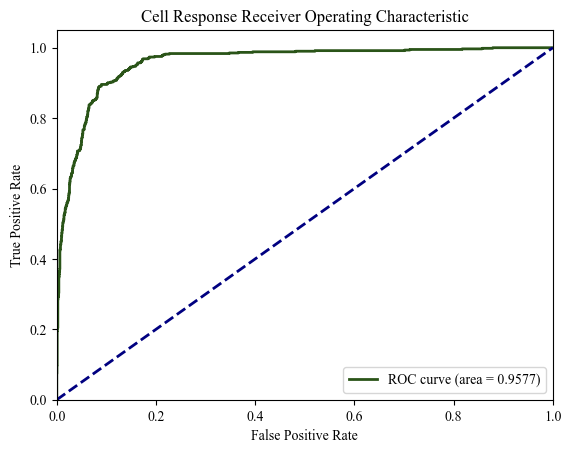

In [71]:
# Evaluation
model.eval()
y_true = []
y_pred = []
y_score = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())



# Calculating metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
y_test_binarized = label_binarize(y_true, classes=np.unique(y_true))

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr')
cohen_kappa = cohen_kappa_score(y_true, y_pred)
matthews_corr = matthews_corrcoef(y_true, y_pred)

tqdm.write(f'Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}, Cohen Kappa Score: {cohen_kappa}, Matthews Correlation Coefficient: {matthews_corr}')

# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)


# Compute micro-average ROC curve and ROC area
roc_auc_overall = roc_auc_score(y_test_binarized, y_score, average="micro")

# Plotting
plt.figure()
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.4f)' % roc_auc_overall, color='#2a5418')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cell Response Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [73]:
result_df = pd.read_excel(r"D:/mlateV2/final_df/codes/final_df/0/codes/DeepLearning/DeepLearning_Results.xlsx")
result_df

,Dataset,Activation Function,Optimizer,Learning Rate,Dropout,Batch Size,Number of Epochs,Precision,Recall,Accuracy,F1 Score,AUC,Kappa,MCC
0,Printability,LeakyReLU,RMSprop,0.000202,0.16179,64,1100,0.934465,0.929149,0.930769,0.930521,0.960276,0.907523,0.908264


In [75]:
Classification_data = {
    'Dataset': 'Cell Response', 
    'Activation Function': 'ReLU6', 
    'Optimizer': 'Adamax',
    'criterion': 'CrossEntropyLoss',
    'Learning Rate': 0.0018458491490272444, 
    'Dropout': 0.30643691730848593,
    'Batch Size': 128,
    'Number of Epochs': 1759, 
    'Precision': precision,
    'Recall': recall, 
    'Accuracy': accuracy, 
    'F1 Score': f1, 
    'AUC': roc_auc, 
    'Kappa': cohen_kappa, 
    'MCC': matthews_corr
}

# Append the new data as a row to the DataFrame
result_df = pd.concat([result_df, pd.DataFrame([Classification_data])], ignore_index=True)
result_df

,Dataset,Activation Function,Optimizer,Learning Rate,Dropout,Batch Size,Number of Epochs,Precision,Recall,Accuracy,F1 Score,AUC,Kappa,MCC,criterion
0,Printability,LeakyReLU,RMSprop,0.000202,0.161790,64,1100,0.934465,0.929149,0.930769,0.930521,0.960276,0.907523,0.908264,NaN
1,Cell Response,ReLU6,Adamax,0.001846,0.306437,128,1759,0.800032,0.801735,0.798013,0.795903,0.957672,0.747473,0.749877,CrossEntropyLoss


In [77]:
result_df.to_excel(r"D:/mlateV2/final_df/codes/final_df/0/codes/DeepLearning/DeepLearning_Results.xlsx", index=False)

C:\Users\saeed\AppData\Local\Temp\ipykernel_22536\3709850196.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  result_df.to_excel(r"D:/mlateV2/final_df/codes/final_df/0/codes/DeepLearning/DeepLearning_Results.xlsx", index=False)
